In [1]:
# based on https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/data
#and https://github.com/imlab-uiip/keras-segnet/blob/master/build_model.py

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
n_labels = 1

TRAIN_PATH = '../PennFudanPed/TRAIN/'
TEST_PATH = '../PennFudanPed/TEST/'
MASK_PATH  = 'PedMasks'

IMAGE_PATH = 'PNGImages'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [3]:
train_img_ids = next(os.walk(TRAIN_PATH+IMAGE_PATH))[2]

train_mask_ids = next(os.walk(TRAIN_PATH+MASK_PATH))[2]
test_ids = next(os.walk(TEST_PATH+IMAGE_PATH))[2]
print(test_ids)

['PennPed00090.png', 'PennPed00096.png', 'PennPed00085.png', 'PennPed00094.png', 'PennPed00088.png', 'PennPed00082.png', 'PennPed00092.png', 'PennPed00086.png', 'PennPed00083.png', 'PennPed00089.png', 'PennPed00081.png', 'PennPed00091.png', 'PennPed00087.png', 'PennPed00084.png', 'PennPed00093.png', 'PennPed00095.png']


In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_img_ids), total=len(train_img_ids)):
    path = TRAIN_PATH + IMAGE_PATH + "/"
    img = imread(path+id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
    path = TRAIN_PATH + MASK_PATH + "/"
    mask_ = imread(path+id_[:-4]+'_mask.png')
    
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    mask = np.where(mask<0.001, 0, 1)
    Y_train[n] = mask


Getting and resizing train images and masks ... 


100%|██████████| 154/154 [00:01<00:00, 99.31it/s] 


In [5]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + IMAGE_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 16/16 [00:00<00:00, 144.67it/s]

Done!


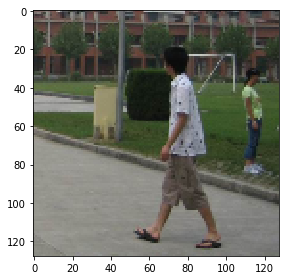

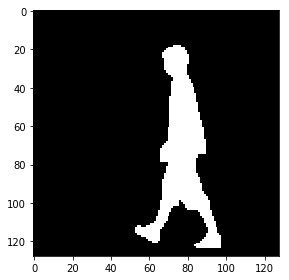

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_img_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
kernel = 3

encoding_layers = [
    Lambda(lambda x: x / 255.0), 
    Conv2D(64, (kernel, kernel), padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS) ),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

model = models.Sequential()
#model.encoding_layers = encoding_layers

for l in encoding_layers:
    model.add(l)

decoding_layers = [
    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(n_labels, (1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu')
]
#model.decoding_layers = decoding_layers
for l in decoding_layers:
    model.add(l)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

In [9]:
#model.summary()

In [10]:
from keras.utils import plot_model
plot_model(model, to_file='segnet_model.png')

In [11]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('segnet.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 138 samples, validate on 16 samples
Epoch 1/50
138/138 [==============================] - 8s 57ms/step - loss: 1.2816 - mean_iou: 0.4107 - val_loss: 2.9947 - val_mean_iou: 0.4330

Epoch 00001: val_loss improved from inf to 2.99466, saving model to segnet.h5
Epoch 2/50
138/138 [==============================] - 2s 12ms/step - loss: 0.4910 - mean_iou: 0.4289 - val_loss: 2.9298 - val_mean_iou: 0.4258

Epoch 00002: val_loss improved from 2.99466 to 2.92977, saving model to segnet.h5
Epoch 3/50
138/138 [==============================] - 2s 12ms/step - loss: 0.4447 - mean_iou: 0.4234 - val_loss: 2.5564 - val_mean_iou: 0.4218

Epoch 00003: val_loss improved from 2.92977 to 2.55644, saving model to segnet.h5
Epoch 4/50
138/138 [==============================] - 2s 12ms/step - loss: 0.4501 - mean_iou: 0.4205 - val_loss: 2.4992 - val_mean_iou: 0.4197

Epoch 00004: val_loss improved from 2.55644 to 2.49916, saving model to segnet.h5
Epoch 5/50
138/138 [==============================] - 2

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 64)      0         
__________

In [13]:
# Predict on train, val and test
model = load_model('segnet.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))



16/16 [==============================] - 0s 2ms/step


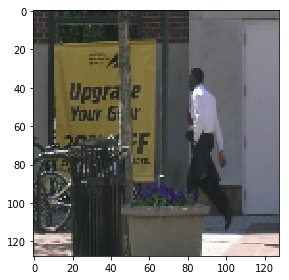

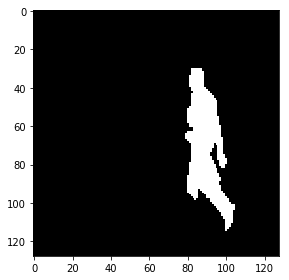

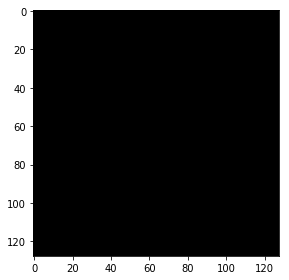

In [14]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()



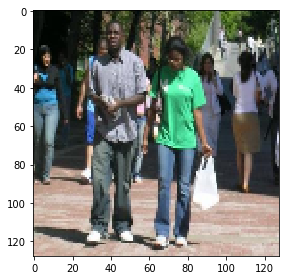

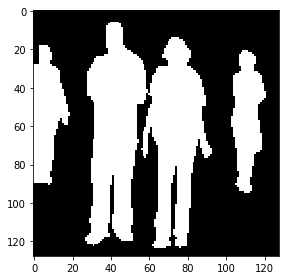

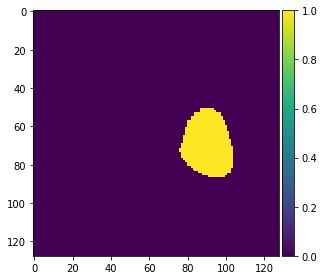

In [15]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

16
154
16
14
4


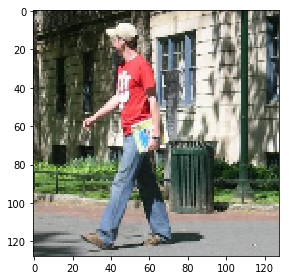

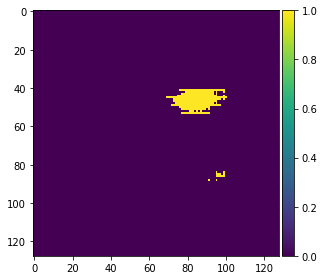

In [16]:
# Perform a sanity check on some random validation samples
print(len(preds_test_t))
ix = random.randint(0, len(preds_test_t))
print(X_train.shape[0])
print(X_test.shape[0])
print(int(X_test.shape[0]*0.9))
print(ix)
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()